In [1]:
import pandas as pd
from pyntcloud import PyntCloud
import numpy as np
import torch
import torch.nn as nn
import pyvista as pv
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import seaborn as sns 

In [2]:
pt = PyntCloud.from_file('../data/birmingham_blocks/birmingham_block_6.ply')

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
help(pt)

Help on PyntCloud in module pyntcloud.core_class object:

class PyntCloud(builtins.object)
 |  PyntCloud(points, mesh=None, structures=None, **kwargs)
 |  
 |  A Pythonic Point Cloud.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, points, mesh=None, structures=None, **kwargs)
 |      Create PyntCloud.
 |      
 |      Parameters
 |      ----------
 |      points: pd.DataFrame
 |          DataFrame of N rows by M columns.
 |          Each row represents one point of the point cloud.
 |          Each column represents one scalar field associated to its corresponding point.
 |      
 |      mesh: pd.DataFrame or None, optional
 |          Default: None
 |          Triangular mesh associated with points.
 |      
 |      structures: dict, optional
 |          Map key(base.Structure.id) to val(base.Structure)
 |      
 |      kwargs: custom attributes
 |  
 |  __repr__(self)
 |      Return repr(self).
 |  
 |  add_scalar_field(self, name, **kwargs)
 |      Add one or multiple column

In [5]:
pt.points

,x,y,z,red,green,blue,class
0,437.12500,1255.12500,9.480003,118,155,96,1
1,435.84375,1254.18750,9.349998,88,116,76,1
2,447.34375,1261.78125,10.750000,48,83,33,1
3,447.03125,1260.50000,11.950005,118,155,58,1
4,443.56250,1257.87500,10.480003,88,122,43,1
...,...,...,...,...,...,...,...
17058908,579.68750,1234.12500,16.610001,191,180,159,2
17058909,582.06250,1234.96875,16.770004,190,192,172,2
17058910,580.62500,1234.62500,16.900002,208,203,179,2
17058911,578.68750,1234.06250,16.880005,104,98,86,2


Points normalization

In [6]:
coords = pt.points[['x', 'y', 'z']].values

x = (coords[:, 0] - np.mean(coords[:, 0])) / np.std(coords[:, 0])
y = (coords[:, 1] - np.mean(coords[:, 1])) / np.std(coords[:, 1])
z = (coords[:, 2] - np.mean(coords[:, 2])) / np.std(coords[:, 2])

normalized_cloud = np.column_stack([x, y, z])

In [216]:
classes = pt.points['class'].unique().astype(int)
colors = np.random.uniform(size=(len(classes), 3))
colored_classes = pd.DataFrame(colors, index=classes, columns=['r', 'g', 'b'])

In [217]:
colored_classes

,r,g,b
1,0.559884,0.325976,0.457002
0,0.100429,0.539634,0.354281
2,0.051635,0.020060,0.237894
7,0.594648,0.984412,0.107519
9,0.685452,0.235286,0.556800
8,0.234875,0.235653,0.774188
3,0.449444,0.874858,0.879502
12,0.572330,0.901426,0.057742
5,0.478841,0.870775,0.929059
10,0.972543,0.213485,0.503134


In [220]:
colored_classes.loc[np.array([1, 2, 3, 1, 1])]

,r,g,b
1,0.559884,0.325976,0.457002
2,0.051635,0.020060,0.237894
3,0.449444,0.874858,0.879502
1,0.559884,0.325976,0.457002
1,0.559884,0.325976,0.457002


In [7]:
point_cloud = pv.PolyData(normalized_cloud)
point_cloud.cell_data['colors'] = pt.points[['red', 'green', 'blue']].values

C:\Users\julia\anaconda3\envs\scene-recon\lib\site-packages\pyvista\jupyter\notebook.py:37: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (C:\Users\julia\anaconda3\envs\scene-recon\lib\site-packages\trame\widgets\__init__.py)

Falling back to a static output.
  warnings.warn(


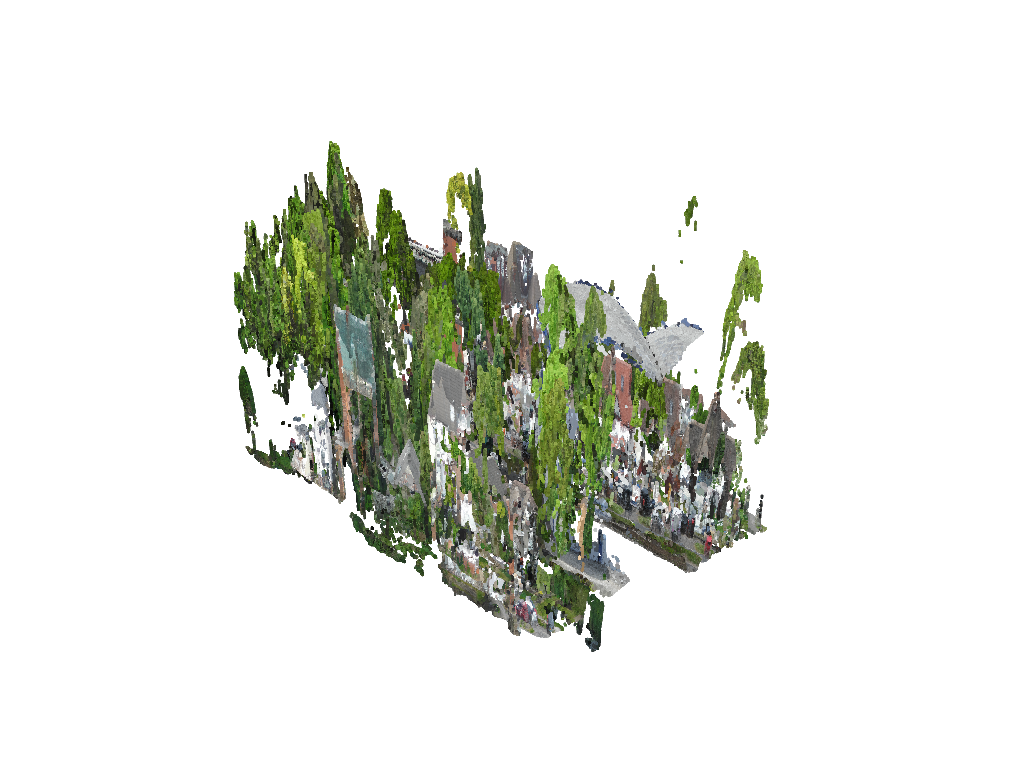

In [8]:
# Viz works better outside of notebook environment
plotter = pv.Plotter(notebook=True)
plotter.add_mesh(point_cloud, point_size=3, render_points_as_spheres=True,
                 scalars='colors', lighting=False, rgb=True, preference='cell')
plotter.show()

In [9]:
print(x.min(), y.min(), z.min())
print(x.max(), y.max(), z.max())

-1.6989777 -1.7268995 -1.7327157
1.728675 2.1121788 2.8223448


In [10]:
classes_count = pd.DataFrame(pt.points['class']).value_counts().reset_index().set_index('class')

In [11]:
classes_count

,count
class,
2,5450877
1,5238617
0,3648426
7,1349248
9,327182
3,295100
8,274296
5,255924
10,153411


In [12]:
classes_df = pd.DataFrame.from_dict({'class': np.arange(13), 'name': ['ground', 'vegetation', 'building', 'wall', 'bridge', 
    'parking', 'rail', 'traffic road', 'street furniture', 
                                                                      'car', 'footpath', 'bike', 'water']}).set_index('class')
classes_df

,name
class,
0,ground
1,vegetation
2,building
3,wall
4,bridge
5,parking
6,rail
7,traffic road
8,street furniture


In [13]:
"""classes_df = pd.DataFrame.from_dict({'label': [1, 2, 3, 4, 5, 0], 'name': ['building', 'green area', 'car', 'ground', 'tree', 'road']}).set_index('label')
classes_df"""

"classes_df = pd.DataFrame.from_dict({'label': [1, 2, 3, 4, 5, 0], 'name': ['building', 'green area', 'car', 'ground', 'tree', 'road']}).set_index('label')\nclasses_df"

In [14]:
counts = classes_df.join(classes_count).fillna(0)

Observations
- some classes are not present at all
- classes are imbalanced

In [15]:
counts

,name,count
class,,
0,ground,3648426.0
1,vegetation,5238617.0
2,building,5450877.0
3,wall,295100.0
4,bridge,0.0
5,parking,255924.0
6,rail,0.0
7,traffic road,1349248.0
8,street furniture,274296.0


In [41]:
re_classed_counts = counts[counts['count'] > 0].reset_index()
re_classed_counts

,class,name,count
0,0,ground,3648426.0
1,1,vegetation,5238617.0
2,2,building,5450877.0
3,3,wall,295100.0
4,5,parking,255924.0
5,7,traffic road,1349248.0
6,8,street furniture,274296.0
7,9,car,327182.0
8,10,footpath,153411.0
9,12,water,65832.0


In [45]:
# remapping classes
re_classed_counts[re_classed_counts['class'] == 12].index[0]

np.int64(9)

<Axes: xlabel='count', ylabel='name'>

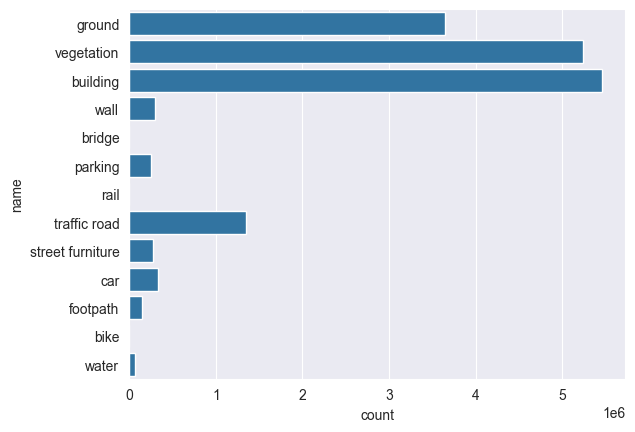

In [16]:
sns.barplot(counts, y='name', x='count')

In [17]:
torch.eye(3).repeat(2, 1, 1)

tensor([[[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]],

        [[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]]])

In [18]:
# pool of size=3, stride=2
m = nn.MaxPool1d(3, stride=2)
input = torch.randn(20, 16, 50)
output = m(input)

In [19]:
output.shape

torch.Size([20, 16, 24])

#### Point Net Implementation

In [47]:
import numpy as np
import torch.nn.functional as F
import pytorch_lightning as pl

In [64]:
class Tnet(nn.Module):
   def __init__(self, k=3):
      super().__init__()
      self.k=k
      self.conv1 = nn.Conv1d(k,64,1)
      self.conv2 = nn.Conv1d(64,128,1)
      self.conv3 = nn.Conv1d(128,1024,1)
      self.fc1 = nn.Linear(1024,512)
      self.fc2 = nn.Linear(512,256)
      self.fc3 = nn.Linear(256,k*k)

      self.bn1 = nn.BatchNorm1d(64)
      self.bn2 = nn.BatchNorm1d(128)
      self.bn3 = nn.BatchNorm1d(1024)
      self.bn4 = nn.BatchNorm1d(512)
      self.bn5 = nn.BatchNorm1d(256)
       
   def forward(self, input):
        # input.shape == (bs, n, 3)
        bs = input.size(0)
        xb = F.relu(self.bn1(self.conv1(input)))
        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = F.relu(self.bn3(self.conv3(xb)))
        pool = nn.MaxPool1d(xb.size(-1))(xb)
        flat = nn.Flatten()(pool) # (bs, 1024)
        xb = F.relu(self.bn4(self.fc1(flat))) # (bs, 512)
        xb = F.relu(self.bn5(self.fc2(xb))) # (bs, 256)
        
        #initialize as identity
        init = torch.eye(self.k, requires_grad=True).repeat(bs, 1, 1)
        if xb.is_cuda:
            init=init.cuda()
        matrix = self.fc3(xb).view(-1, self.k, self.k) + init
        return matrix
      
      
t_net = Tnet(k=3)
matrix_3x3 = t_net.forward(torch.randn(10, 1024, 3).transpose(2, 1))
matrix_3x3.shape

torch.Size([10, 3, 3])

In [65]:
class Transform(nn.Module):
   def __init__(self):
        super().__init__()
        self.input_transform = Tnet(k=3)
        self.feature_transform = Tnet(k=64)
        self.conv1 = nn.Conv1d(3,64,1)
        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)
       

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
       
   def forward(self, input):
        matrix3x3 = self.input_transform(input)
        # batch matrix multiplication
        xb = torch.bmm(torch.transpose(input,1,2), matrix3x3).transpose(1,2) # why transpose?

        xb = F.relu(self.bn1(self.conv1(xb)))

        matrix64x64 = self.feature_transform(xb)
        xb = torch.bmm(torch.transpose(xb,1,2), matrix64x64).transpose(1,2)

        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = self.bn3(self.conv3(xb))
        xb = nn.MaxPool1d(xb.size(-1))(xb) # global feature (bs, 1024, 1?)
        output = nn.Flatten()(xb)
        return output, matrix3x3, matrix64x64
   
transform_net = Transform()
out, m3x3, m64x64 = transform_net.forward(torch.randn(10, 1024, 3).transpose(2, 1))
print(out.shape)

torch.Size([10, 1024])


In [66]:
mat = torch.randn(10, 1024, 3)
print(mat[0, 0])
pooling_result = nn.MaxPool1d(3)(mat)
print(pooling_result.shape)

tensor([-0.5002, -1.7890,  0.0297])
torch.Size([10, 1024, 1])


In [67]:
nn.Flatten()(pooling_result).shape

torch.Size([10, 1024])

In [76]:
class PointNetClassifier(pl.LightningModule):
    def __init__(self, classes = 10):
        super().__init__()
        self.transform = Transform()
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, classes)
        
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, input):
        xb, matrix3x3, matrix64x64 = self.transform(input)
        xb = F.relu(self.bn1(self.fc1(xb)))
        xb = F.relu(self.bn2(self.dropout(self.fc2(xb))))
        output = self.fc3(xb)
        return output, matrix3x3, matrix64x64
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        predictions, matrix3x3, matrix64x64 = self(x)
        loss = F.cross_entropy(predictions, y)
        self.log('train_loss', loss, prog_bar=True, sync_dist=True, on_epoch=True)
        return {'loss': loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        predictions, matrix3x3, matrix64x64 = self(x)
        loss = F.cross_entropy(predictions, y)
        self.log('val_loss', loss, prog_bar=True, sync_dist=True, on_epoch=True)
        return {'val_loss': loss}

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x, y = batch
        predictions, matrix3x3, matrix64x64 = self(x)
        predicted_labels = torch.argmax(predictions, dim=-1)
        return predicted_labels

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

Steps

1. Dataset for reading a point cloud
2. ? Applying transformations like rotation? 
3. Subsampling point cloud 

In [78]:
point_net = PointNetClassifier()
logits, m3x3, m64x64 = point_net.forward(torch.randn(10, 1024, 3).transpose(2, 1))
logits.shape

torch.Size([10, 10])

In [197]:
class PointCloudClassificationDataset(Dataset):
    
    def __init__(self, point_cloud_path, subsample_size, point_sampler, classes_df):
        self.subsample_size = subsample_size
        self.point_sampler = point_sampler
        self.pt = PyntCloud.from_file(point_cloud_path)
        x = (self.pt.points['x'] - np.mean(self.pt.points['x'])) / np.std(self.pt.points['x'])
        y = (self.pt.points['y'] - np.mean(self.pt.points['y'])) / np.std(self.pt.points['y'])
        z = (self.pt.points['z'] - np.mean(self.pt.points['z'])) / np.std(self.pt.points['z'])
        
        self.pt.points['x_norm'] = x 
        self.pt.points['y_norm'] = y
        self.pt.points['z_norm'] = z


        # select classes with non-zero count
        counts = classes_df.join(classes_count).fillna(0)
        self.classes = counts[counts['count'] > 0].reset_index(drop=True)
        
    def __len__(self):
        return self.subsample_size
    
    def __getitem__(self, idx):
        chosen_class = idx % len(self.classes)
        sampled_cloud = self.point_sampler(self.pt.points.loc[self.pt.points['class'] == chosen_class, 
                ['x_norm', 'y_norm', 'z_norm']])
        sampled_points = torch.tensor(sampled_cloud[['x_norm', 'y_norm', 'z_norm']].values, device=device)
        label = torch.scalar_tensor(chosen_class, device=device, dtype=torch.long)
        return sampled_points.T, label 

### Segmentation network

In [190]:
class Transform_2(nn.Module):
   def __init__(self):
        super().__init__()
        self.input_transform = Tnet(k=3)
        self.feature_transform = Tnet(k=64)
        self.conv1 = nn.Conv1d(3,64,1)
        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)
       
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
       
   def forward(self, input):
        matrix3x3 = self.input_transform(input)
        # batch matrix multiplication
        xb = torch.bmm(torch.transpose(input, 1, 2), matrix3x3).transpose(1, 2) # why transpose?

        xb = F.relu(self.bn1(self.conv1(xb)))

        matrix64x64 = self.feature_transform(xb)
        xb = torch.bmm(torch.transpose(xb, 1, 2), matrix64x64).transpose(1, 2) 
        
        global_xb = F.relu(self.bn2(self.conv2(xb)))
        global_xb = self.bn3(self.conv3(global_xb))
        global_xb = nn.MaxPool1d(global_xb.size(-1))(global_xb).transpose(2, 1) # global feature (bs, 1024, 1?)
        
        return xb, global_xb, matrix3x3, matrix64x64
   
transform_net_2 = Transform_2()
x, g_x, _, _ = transform_net_2.forward(torch.randn(10, 1024, 3).transpose(2, 1))
x.shape, g_x.shape

(torch.Size([10, 64, 1024]), torch.Size([10, 1, 1024]))

In [191]:
g = torch.repeat_interleave(g_x, 1024, dim=1)
g.shape

torch.Size([10, 1024, 1024])

In [192]:
x.transpose(1, 2).shape

torch.Size([10, 1024, 64])

In [193]:
torch.concat([x.transpose(1, 2), g], dim=2).shape

torch.Size([10, 1024, 1088])

In [179]:
class PointNetSegmentor(pl.LightningModule):
    def __init__(self, classes = 10):
        super().__init__()
        self.transform = Transform_2()
        self.conv1 = nn.Conv1d(1088, 512, 1)
        self.conv2 = nn.Conv1d(512, 256, 1)
        self.conv3 = nn.Conv1d(256, 128, 1)
        self.conv4 = nn.Conv1d(128, classes, 1)
        
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.bn3 = nn.BatchNorm1d(128)
        self.bn4 = nn.BatchNorm1d(classes)
        
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, input):
        xb, g_x, matrix3x3, matrix64x64 = self.transform(input)  # xb is of shape (bs, 63, cld_s)
        
        g = torch.repeat_interleave(g_x, 1024, dim=1)
        x = torch.concat([xb.transpose(1, 2), g], dim=2).transpose(1, 2) # concatenate global and per-point features
        
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.dropout(self.bn4(self.conv4(x))))
        
        return x, matrix3x3, matrix64x64
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        predictions, matrix3x3, matrix64x64 = self(x)
        loss = F.cross_entropy(predictions, y)
        self.log('train_loss', loss, prog_bar=True, sync_dist=True, on_epoch=True)
        return {'loss': loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        predictions, matrix3x3, matrix64x64 = self(x)
        loss = F.cross_entropy(predictions, y)
        self.log('val_loss', loss, prog_bar=True, sync_dist=True, on_epoch=True)
        return {'val_loss': loss}

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x, y = batch
        predictions, matrix3x3, matrix64x64 = self(x)
        predicted_labels = torch.argmax(predictions, dim=-1)
        return predicted_labels

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [180]:
segmentor = PointNetSegmentor(6)
logits, m3x3, m64x64 = segmentor.forward(torch.randn(10, 1024, 3).transpose(2, 1))

In [194]:
logits.shape # (bs, # of classes, cld_s)

torch.Size([10, 6, 1024])

In [187]:
F.cross_entropy(logits, torch.randint(low=0, high=6, size=(10, 1024)))

tensor(2.0822, grad_fn=<NllLoss2DBackward0>)

#### Dataset Challenges
- subsampling original clouds?
- how to normalize point cloud
- subsampling read-in clouds?
- reading from multiple clouds
- class imbalance

In [198]:
class PointSampler: # Smarter way to sample point cloud?
    
    def __init__(self, subsample_size):
        self.subsample_size = subsample_size
    
    def __call__(self, point_cloud):
        indices = np.random.choice(point_cloud.index.values, size=self.subsample_size, replace=False)
        sampled_points = point_cloud.loc[indices]
        return sampled_points
    

class PointCloudSegmentationDataset(Dataset):
    
    def __init__(self, point_cloud_path, subsample_size, point_sampler):
        self.subsample_size = subsample_size
        self.point_sampler = point_sampler
        self.pt = PyntCloud.from_file(point_cloud_path)
        
        x = (self.pt.points['x'] - np.mean(self.pt.points['x'])) / np.std(self.pt.points['x'])
        y = (self.pt.points['y'] - np.mean(self.pt.points['y'])) / np.std(self.pt.points['y'])
        z = (self.pt.points['z'] - np.mean(self.pt.points['z'])) / np.std(self.pt.points['z'])
        
        self.pt.points['x_norm'] = x 
        self.pt.points['y_norm'] = y
        self.pt.points['z_norm'] = z 
        
    def __len__(self):
        return self.subsample_size
    
    def __getitem__(self, idx):
        sampled_cloud = self.point_sampler(self.pt.points[['x_norm', 'y_norm', 'z_norm', 'class']])
        sampled_points = torch.tensor(sampled_cloud[['x_norm', 'y_norm', 'z_norm']].values, device=device)
        labels = torch.tensor(sampled_cloud[['class']].values, device=device, dtype=torch.long).flatten()
        return sampled_points, labels
    

In [199]:
subsample_size = 1024
training_dataset = PointCloudSegmentationDataset('../data/birmingham_blocks/birmingham_block_6.ply', 
                                     subsample_size=subsample_size, point_sampler=PointSampler(subsample_size=subsample_size))

In [200]:
train_loader = DataLoader(training_dataset, batch_size=32, shuffle=True)

Each batch is a sampled point cloud

In [201]:
for row in train_loader:
    cloud, labels = row 
    batch = row
    print(cloud.shape)
    print(labels.shape)
    print(labels)
    break

torch.Size([32, 1024, 3])
torch.Size([32, 1024])
tensor([[0, 0, 1,  ..., 0, 1, 2],
        [7, 1, 8,  ..., 8, 5, 1],
        [1, 2, 2,  ..., 7, 0, 1],
        ...,
        [2, 0, 2,  ..., 0, 0, 7],
        [0, 1, 5,  ..., 1, 1, 1],
        [1, 2, 1,  ..., 1, 2, 1]], device='cuda:0')


In [209]:
cloud[0].cpu().detach().numpy()

array([[ 1.6628925 , -0.82782227, -0.15653755],
       [-0.8940397 , -1.7190368 , -1.0033828 ],
       [ 0.85850805, -1.14812   ,  0.833935  ],
       ...,
       [ 0.10325269,  1.6041932 , -0.9157136 ],
       [ 1.2529285 , -0.7446572 ,  1.8915584 ],
       [-0.25841498,  0.6927493 ,  1.4401567 ]], dtype=float32)

C:\Users\julia\anaconda3\envs\scene-recon\lib\site-packages\pyvista\jupyter\notebook.py:37: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (C:\Users\julia\anaconda3\envs\scene-recon\lib\site-packages\trame\widgets\__init__.py)

Falling back to a static output.
  warnings.warn(


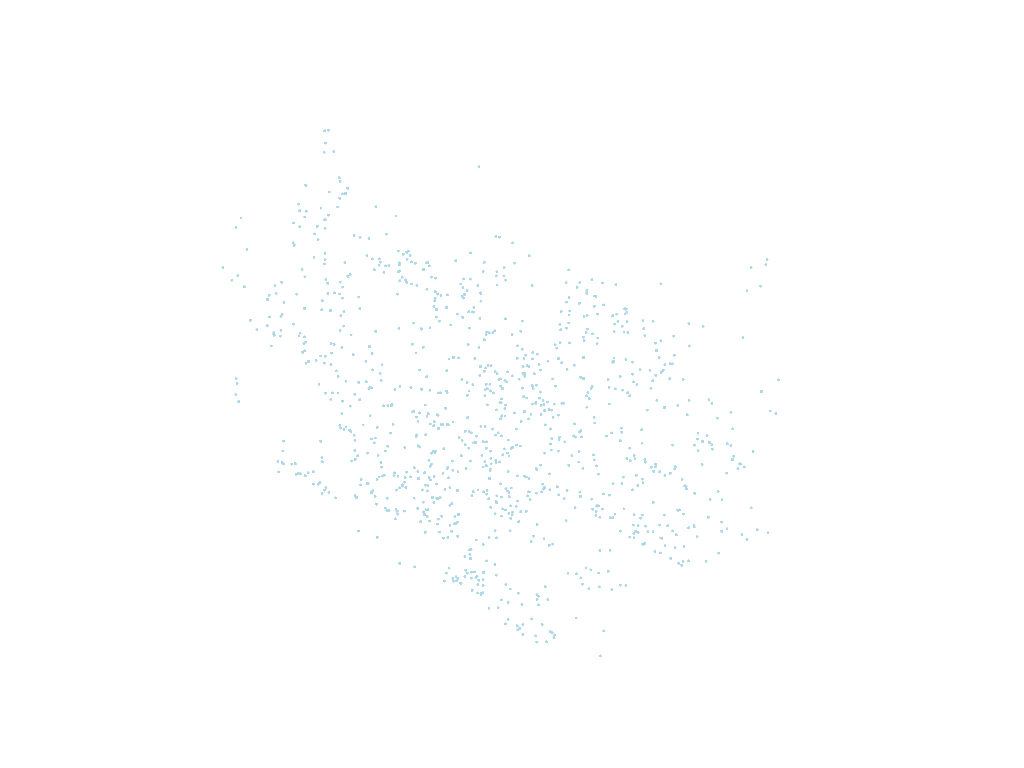

In [211]:
point_cloud = pv.PolyData(cloud[0].cpu().detach().numpy())

# Viz works better outside of notebook environment
plotter = pv.Plotter(notebook=True)
plotter.add_mesh(point_cloud, point_size=3, render_points_as_spheres=True,
                 lighting=False, preference='cell')
plotter.show()

C:\Users\julia\anaconda3\envs\scene-recon\lib\site-packages\pyvista\jupyter\notebook.py:37: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (C:\Users\julia\anaconda3\envs\scene-recon\lib\site-packages\trame\widgets\__init__.py)

Falling back to a static output.
  warnings.warn(


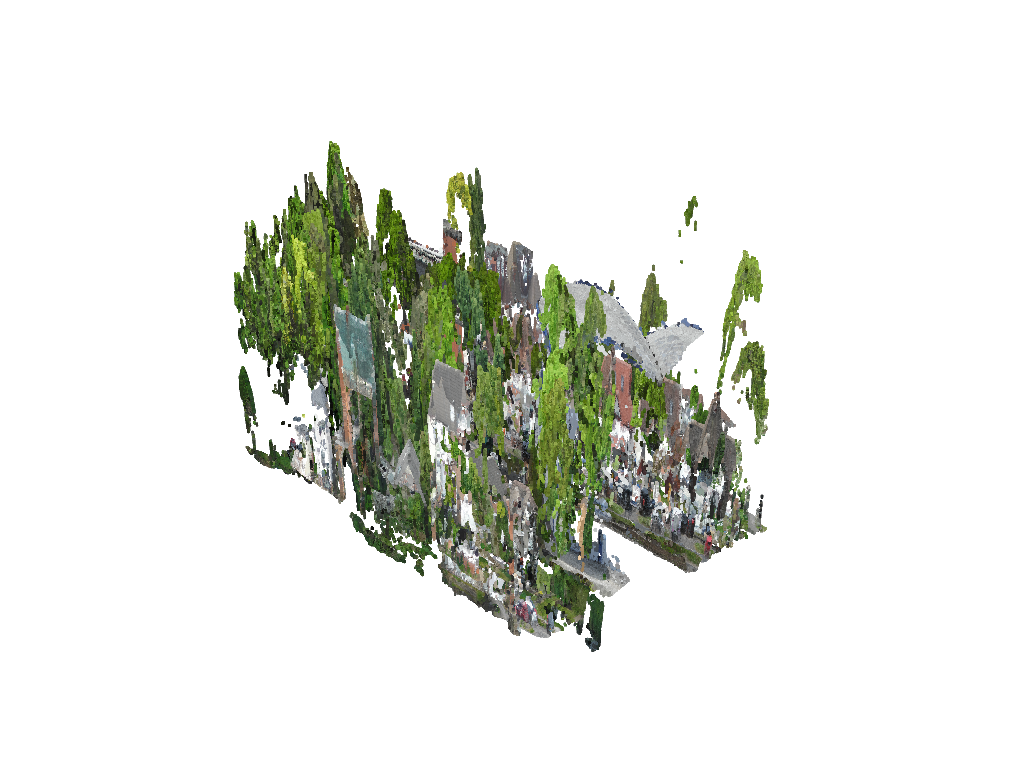

In [8]:
# Viz works better outside of notebook environment
plotter = pv.Plotter(notebook=True)
plotter.add_mesh(point_cloud, point_size=3, render_points_as_spheres=True,
                 scalars='colors', lighting=False, rgb=True, preference='cell')
plotter.show()

tensor([[[ 1.6629, -0.8278, -0.1565],
         [-0.8940, -1.7190, -1.0034],
         [ 0.8585, -1.1481,  0.8339],
         ...,
         [ 0.1033,  1.6042, -0.9157],
         [ 1.2529, -0.7447,  1.8916],
         [-0.2584,  0.6927,  1.4402]],

        [[-0.6984,  1.4648, -1.1638],
         [ 1.4714, -0.2266,  0.3713],
         [ 1.6140, -1.0301, -0.2200],
         ...,
         [-1.1047, -0.3401, -0.9493],
         [ 0.0439,  0.1050, -1.0183],
         [ 0.7791, -0.8582, -0.6714]],

        [[ 1.1358, -0.9110,  1.5502],
         [-0.9404,  0.0656, -0.7963],
         [ 1.6049,  0.5006,  0.7537],
         ...,
         [-0.8055,  1.1636, -1.1172],
         [ 0.3728,  0.9231, -1.4529],
         [ 1.0534, -0.5165,  0.1139]],

        ...,

        [[ 1.6954,  0.3095,  0.5896],
         [-0.9165, -1.3459, -1.0258],
         [ 1.6593, -0.1771,  0.7742],
         ...,
         [-1.5169,  1.1389, -0.9922],
         [-1.2529, -0.2378, -1.0071],
         [-0.3656, -0.1243, -0.9568]],

        [[

In [202]:
model = PointNetSegmentor(classes=len(classes_count))

In [29]:
checkpoint_dir = Path("../data/models/segmentation-1")

max_epochs = 10

checkpoint_callback = pl.callbacks.ModelCheckpoint(dirpath=checkpoint_dir / 'best_results', filename='{epoch}-{val_loss:.2f}-{train_loss:.2f}', 
                                      monitor='val_loss', save_last=True) 
early_stopping = pl.callbacks.EarlyStopping(monitor='val_loss', verbose=True)

trainer = pl.Trainer(max_epochs=max_epochs, fast_dev_run=True, 
                     default_root_dir=checkpoint_dir, callbacks=[checkpoint_callback])

trainer.fit(model, train_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\julia\anaconda3\envs\scene-recon\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.
C:\Users\julia\anaconda3\envs\scene-recon\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
You are using a CUDA d

Training: |          | 0/? [00:00<?, ?it/s]

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [71]:
for row in train_loader:
    cloud, labels = row 
    batch = row
    print(cloud.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 1024])
torch.Size([32])


In [72]:
cloud.cpu()

tensor([[[ 1.5728, -0.0262,  0.4831,  ...,  0.4958, -0.2065,  1.6795],
         [ 0.2093, -0.0506,  1.2042,  ...,  0.1887,  1.1872,  0.8473],
         [ 0.5837,  0.7462, -1.0304,  ...,  0.2434,  0.9163, -0.2285]],

        [[-1.4257, -0.7780, -0.1112,  ..., -0.1913, -0.0541,  0.3688],
         [ 1.5647,  1.4494, -0.3335,  ..., -0.3558, -0.7739,  1.2912],
         [-0.6075, -0.7674, -0.6926,  ..., -0.5972, -0.7596, -0.8344]],

        [[-1.2428, -1.1895,  0.7397,  ...,  1.6414, -1.1615, -0.5926],
         [ 0.8079,  1.0696,  1.1237,  ...,  0.2063, -0.2582,  0.2587],
         [-0.2053, -0.7313,  1.5790,  ..., -0.6101, -0.3161,  2.8914]],

        ...,

        [[-0.2154,  1.6579, -1.2136,  ...,  1.2781, -0.8885,  0.7397],
         [-1.2872,  0.1128,  0.7808,  ..., -1.7806,  0.2546,  0.5833],
         [-0.1589, -0.9633, -0.3368,  ..., -0.6900, -0.3368, -0.6823]],

        [[-0.8250,  0.1783,  0.1301,  ...,  0.2469, -1.1641,  0.0208],
         [-0.0706,  1.4729, -0.5604,  ...,  1.6447,  1.

In [73]:
from sklearn.metrics import classification_report, f1_score, precision_recall_fscore_support

logits, _, _ = model(cloud.cpu())
classes = torch.argmax(logits, axis=1)

print(classification_report(labels.cpu(), classes))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         6

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32

